In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import re
import os

os.chdir('..')
os.chdir('results')

In [2]:
def get_path(dataset='FordA', model_name='ResidualCNN', reg=True, exp_name=None):
    attack_type = 'fgsm_disc_attack' if reg else 'fgsm_attack'
    exp = '_' + exp_name if exp_name else ''
    
    path = '/'.join([dataset, model_name, 'attack', attack_type + exp])

    return path



def combined_df(dataset='FordA', model_name='ResidualCNN', reg=True, exp_name=None):

    path = get_path(dataset=dataset, model_name=model_name, reg=reg, exp_name=exp_name)
    
    files = os.listdir(path)
    files = [f for f in files if f.endswith('.csv')]

    pattern = r"(?<==).*?(?=.csv)"
    id_pattern = fr"(?<={dataset}_).*?(?=_alpha)"

    all_res = pd.DataFrame()

    for file in files:
        curr_res = pd.read_csv(path + '/' + file, index_col=0)

        curr_res['alpha'] = float(re.search(pattern, file)[0])
        curr_res['model_id'] = re.search(id_pattern, file)[0]

        curr_res.columns = [column.strip(' ') for column in curr_res.columns] 

        all_res = pd.concat([all_res, curr_res], axis=0)

    return all_res.reset_index(drop=True)

def aggregated_results(
    dataset='FordA', 
    model_name='ResidualCNN', 
    exp_name='',
    reg=True,  
    metr='F_EFF_CONC',
    metr_max=True,
    k=1,
    vis = False,
    params=['ACC', 'PROB_HID'],
    figsize=(20, 30),
    save_pic=False):

    all_df = combined_df(dataset=dataset, model_name=model_name, reg=reg, exp_name=exp_name)

    grouped = all_df.groupby(['eps', 'alpha'])
    result = grouped.apply(lambda x: x.nlargest(k, metr, keep='last') if metr_max else x.nsmallest(k, metr, keep='last'))


    if vis:
        
        fig, ax = plt.subplots(result['alpha'].nunique(), result['eps'].nunique(), figsize=figsize, sharey=True)
        fig.suptitle(f'{dataset}_{model_name}')

        all_alps = result['alpha'].unique()
        all_eps = result['eps'].unique()

        path = get_path(dataset=dataset, model_name=model_name, reg=reg, exp_name=exp_name)

        for i, row in result.iterrows():

            alp = int(row['alpha']) if row['alpha'].is_integer() else row['alpha']
            eps = row['eps']

            file_path = path + '/' + f'aa_res_{dataset}_{int(row["model_id"])}_alpha={alp}.csv'

            curr_df = pd.read_csv(file_path, index_col=0)
            curr_df.columns = [column.strip(' ') for column in curr_df.columns]

            curr_df = curr_df[curr_df['eps']==eps].set_index('step_id')

            eps_id = np.where(all_eps==eps)[0][0]
            alp_id = np.where(all_alps==alp)[0][0]

            ax[alp_id, eps_id].plot(curr_df[params])
            ax[alp_id, eps_id].axvline(int(row["step_id"]), ls='--', alpha=0.2, color='black')

            ax[alp_id, eps_id].set_title(f'eps={eps}, alpha={alp}, {metr}={row[metr]}, step={int(row["step_id"])}')
            ax[alp_id, eps_id].legend(params)
        
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)

        if save_pic:
            plt.savefig(f'../{dataset}_{model_name}.jpeg', dpi=120)

    return result

In [3]:
aggregated_results(dataset='Coffee', model_name='PatchTST', exp_name="MODE", vis=False, params=['ACC', 'PROB_HID', 'ACC_DISC'])

ACC     ROC      PR      F1     EFF        L1  \
eps   alpha                                                           
0.005 0.001   16   0.4286  0.4359  0.4360  0.4667  0.5333   17.6482   
      0.010   641  0.3214  0.3000  0.4643  0.0000  1.0000   29.4750   
      0.100   356  0.5000  0.4667  0.4643  0.0000  1.0000   50.2082   
      1.000   203  0.6071  0.5769  0.5467  0.2667  0.7333   53.5750   
      10.000  815  0.6786  0.6538  0.6291  0.4706  0.5294   53.8953   
      100.000 509  0.7143  0.6923  0.6703  0.5556  0.4444   53.9639   
0.030 0.001   54   0.4286  0.4308  0.4346  0.4286  0.5714   19.4871   
      0.010   668  0.3571  0.3385  0.4396  0.1000  0.9000   29.5757   
      0.100   407  0.4286  0.4000  0.4643  0.0000  1.0000  250.5277   
      1.000   254  0.5000  0.4667  0.4643  0.0000  1.0000  273.2527   
      10.000  866  0.5714  0.5385  0.5055  0.1429  0.8571  287.7084   
      100.000 560  0.5714  0.5385  0.5055  0.1429  0.8571  289.5941   
0.100 0.001   104  0.1429  0.1333  0.4643  0.0000  1.0000   35.0357   
      0.010   716  0.5000  0.4718  0.4542  0.1250  0.8750   31.7786   
      0.100   458  0.3571  0.3333  0.4643  0.0000  1.0000  368.6785   
      1.000   305  0.5000  0.4667  0.4643  0.0000  1.0000  367.6142   
      10.000  917  0.5714  0.5385  0.5055  0.1429  0.8571  364.4714   
      100.000 611  0.5714  0.5385  0.5055  0.1429  0.8571  358.3928   

                   ACC_CORRECT  ACC_ORIG_ADV  ROUGHNESS  ROUGHNESS_NORM  \
eps   alpha                                                               
0.005 0.001   16        0.4286        0.4286     0.0934          2.4532   
      0.010   641       0.3214        0.3214     0.1656          4.3504   
      0.100   356       0.5000        0.5000     0.3086          8.1058   
      1.000   203       0.6071        0.6071     0.3527          9.2648   
      10.000  815       0.6786        0.6786     0.3690          9.6917   
      100.000 509       0.7143        0.7143     0.3716          9.7624   
0.030 0.001   54        0.4286        0.4286     0.1055          2.7725   
      0.010   668       0.3571        0.3571     0.1724          4.5276   
      0.100   407       0.4286        0.4286     1.7302         45.4484   
      1.000   254       0.5000        0.5000     1.9112         50.2044   
      10.000  866       0.5714        0.5714     2.0888         54.8699   
      100.000 560       0.5714        0.5714     2.0913         54.9344   
0.100 0.001   104       0.1429        0.1429     0.1982          5.2073   
      0.010   716       0.5000        0.5000     0.2171          5.7029   
      0.100   458       0.3571        0.3571     2.6122         68.6186   
      1.000   305       0.5000        0.5000     2.6298         69.0791   
      10.000  917       0.5714        0.5714     2.6525         69.6751   
      100.000 611       0.5714        0.5714     2.6037         68.3945   

                   PROB_HID  ACC_DISC  F1_DISC  ROC_AUC_DISC    CONC  \
eps   alpha                                                            
0.005 0.001   16     0.0123    0.5000   0.0000        0.3099  0.6901   
      0.010   641    0.0794    0.5357   0.1333        0.2181  0.7819   
      0.100   356    0.0000    0.5000   0.0000        0.0000  1.0000   
      1.000   203    0.0000    0.5000   0.0000        0.0000  1.0000   
      10.000  815    0.0000    0.5000   0.0000        0.0000  1.0000   
      100.000 509    0.0000    0.5000   0.0000        0.0000  1.0000   
0.030 0.001   54     0.0096    0.5000   0.0000        0.2258  0.7742   
      0.010   668    0.0188    0.5000   0.0000        0.1416  0.8584   
      0.100   407    0.0000    0.5000   0.0000        0.0000  1.0000   
      1.000   254    0.0000    0.5000   0.0000        0.0000  1.0000   
      10.000  866    0.0000    0.5000   0.0000        0.0000  1.0000   
      100.000 560    0.0000    0.5000   0.0000        0.0000  1.0000   
0.100 0.001   104    0.2615    0.6250   0.4000        0.5497  0.4503   
      0.010   716   

In [5]:
res = pd.DataFrame()

for model in [ 'ResidualCNN', 'RNNA', 'TST', 'S4', 'PatchTST']:
    for ds in ['Coffee', 'GunPoint', 'PowerCons', 'Wafer']:
        try:
            aa = aggregated_results(dataset=ds, model_name=model, exp_name="MODE", k=1000)
            aa['model'] = model
            aa['dataset'] = ds

            res = pd.concat([res, aa], axis=0)
        except:
            print(ds, model)

Wafer S4
Wafer PatchTST


In [6]:
t = res.groupby(['dataset', 'model']).max().reset_index().pivot(index='model', columns='dataset', values='F_EFF_CONC')
t.to_csv('data_model.csv')

In [7]:
tmp = res.groupby(['dataset', 'model'])['F_EFF_CONC'].idxmax().to_frame()

tmp['eps'] = tmp['F_EFF_CONC'].apply(lambda x: x[0])
tmp['alpha'] = tmp['F_EFF_CONC'].apply(lambda x: x[1])
tmp['F_EFF_CONC'] = res.groupby(['dataset', 'model'])['F_EFF_CONC'].max()

In [8]:
tmp.reset_index().pivot(index='model', columns='dataset')

F_EFF_CONC                               eps                     \
dataset         Coffee GunPoint PowerCons   Wafer Coffee GunPoint PowerCons   
model                                                                         
PatchTST           1.0   0.8248  0.711400     NaN  0.005    0.100      0.10   
RNNA               1.0   0.4347  0.252500  0.1039  0.030    0.100      0.03   
ResidualCNN        1.0   0.4716  0.663100  0.7080  0.005    0.005      0.03   
S4                 1.0   1.0000  0.397600     NaN  0.030    0.030      0.10   
TST                1.0   0.3554  0.926621  0.5989  0.005    0.005      0.03   

                    alpha                            
dataset      Wafer Coffee GunPoint PowerCons  Wafer  
model                                                
PatchTST       NaN    0.1    1.000     0.100    NaN  
RNNA         0.030    1.0   10.000     0.100   0.10  
ResidualCNN  0.005   10.0    1.000     1.000  10.00  
S4             NaN    1.0    1.000    10.000    NaN  
TST          0.030    0.1    0.001     0.001   0.01

In [9]:
best_metr = tmp.reset_index().pivot(index='model', columns='dataset')

datasets = best_metr['F_EFF_CONC'].columns
models = best_metr.index

metr = ['ACC', 'PROB_HID', 'ACC_DISC']

save = True

PatchTST Wafer nan
S4 Wafer nan


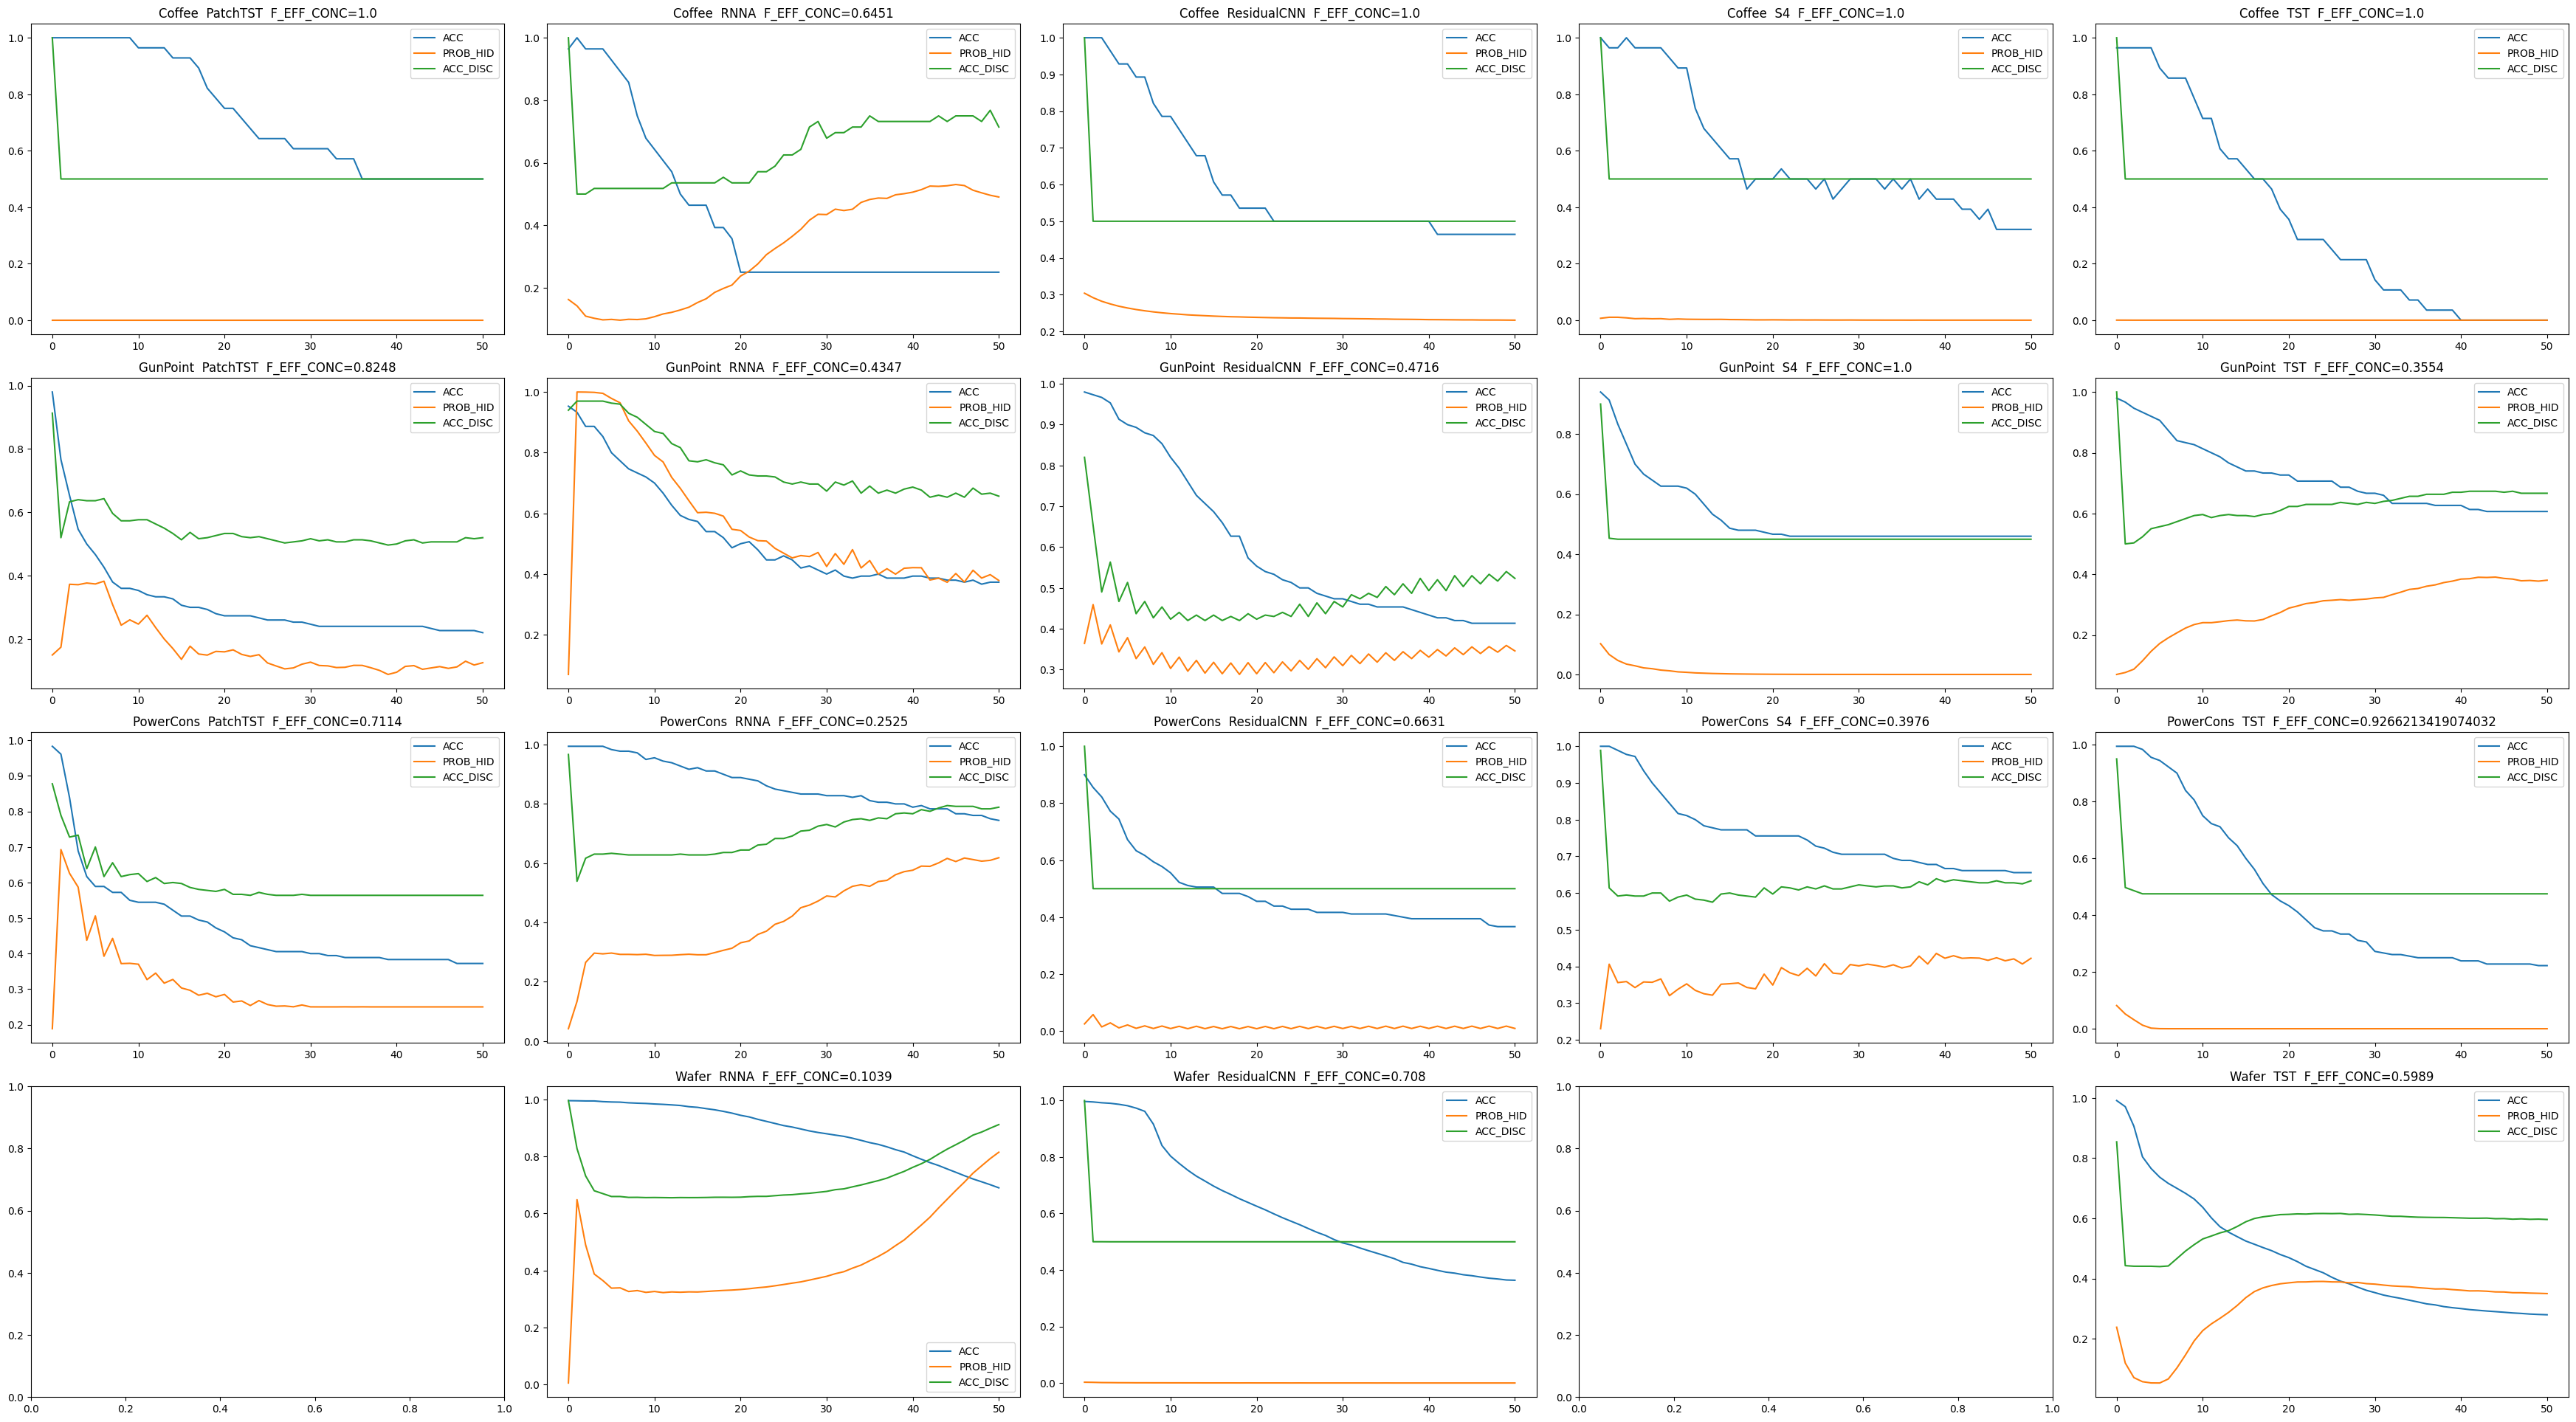

In [9]:
fig, ax = plt.subplots(len(datasets), len(models), figsize=(35, 20))

for i, dataset in enumerate(datasets):
    for j, model in enumerate(models):

        eps = best_metr['eps'].loc[model, dataset]

        alpha = best_metr['alpha'].loc[model, dataset]
        alpha = int(alpha) if alpha.is_integer() else alpha

        path = get_path(dataset, model, exp_name='MODE')

        try:
            curr_res = pd.read_csv(path + '/' + f'aa_res_{dataset}_0_alpha={alpha}.csv', index_col=0)
            curr_res.columns = [col.strip(' ') for col in curr_res.columns]
            
            curr_res = curr_res[curr_res['eps'] == eps].set_index('step_id')
            ax[i, j].plot(curr_res[metr])
            ax[i, j].set_title(f'{dataset}  {model}  F_EFF_CONC={curr_res["F_EFF_CONC"].max()}')
            ax[i, j].legend(metr)

        except:
            print(model, dataset, alpha)
        
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)

if save:
    fig.savefig('../img.jpeg', dpi=200)

In [10]:
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)
os.chdir('..')

from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

import pandas as pd

import torch

from src.config import get_attack, get_criterion, get_disc_list, get_model
from src.data import MyDataset, load_data, transform_data
from src.estimation.estimators import AttackEstimator

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [11]:
params = pd.DataFrame()
ds_len = pd.Series()

In [12]:
datasets = ['Coffee', 'GunPoint', 'PowerCons', 'Wafer']
models = [ 'ResidualCNN', 'RNNA', 'TST', 'S4', 'PatchTST']

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

for ds in datasets:
    for model in models:
        try:
            path = 'results' + '/' + ds + '/' + model + '/attack/fgsm_disc_attack_MODE'
            files = os.listdir(path)
            file = [f for f in files if f.startswith('config_2024')]

            if len(file) > 0:
                cfg = OmegaConf.load(path + '/' + file[-1])
            
            else:
                GlobalHydra.instance().clear()
                initialize(config_path= '../' + path + '/config_folder')
                cfg = compose('attack_run_config.yaml')

            attack_model_path = os.path.join(
                cfg["model_folder"],
                f"model_{cfg['model_id_attack']}_{cfg['dataset']['name']}.pt",
            )

            attack_model = get_model(
                cfg["attack_model"]["name"],
                cfg["attack_model"]["params"],
                path=attack_model_path,
                device=device,
                train_mode=cfg["attack_model"]["attack_train_mode"],
            )
            param_num = sum(p.numel() for p in attack_model.parameters())
            
            params.loc[model, ds] = param_num
            ds_len[ds] = cfg['dataset']['seq_len']

        except:
            print(ds, model, 'error')

PowerCons TST error
PowerCons S4 error
Wafer S4 error
Wafer PatchTST error


In [13]:
agg = res.reset_index(drop=True).copy(deep=True)

In [14]:
gg = agg.copy(deep=True)

In [15]:
for ds in gg['dataset'].unique():
    gg.loc[gg[gg.dataset==ds].index, 'seq_len'] = ds_len[ds]

for ds in datasets:
    for model in models:
        idx = gg[(gg.model==model)&(gg.dataset==ds)].index

        gg.loc[idx, 'param_count'] = params.loc[model, ds]

In [16]:
import seaborn as sns

In [21]:
gg


,ACC,ROC,PR,F1,EFF,L1,ACC_CORRECT,ACC_ORIG_ADV,ROUGHNESS,ROUGHNESS_NORM,...,CONC,F_EFF_CONC,step_id,eps,alpha,model_id,model,dataset,seq_len,param_count
0,0.7143,0.7077,0.6261,0.6667,0.3333,4.7350,0.7143,0.7143,0.0487,1.2783,...,0.2168,0.2628,4.0,0.005,0.001,0,ResidualCNN,Coffee,286.0,256130.0
1,0.2857,0.2872,0.4035,0.2857,0.7143,5.8200,0.2857,0.2857,0.0522,1.3717,...,0.1454,0.2416,5.0,0.005,0.001,0,ResidualCNN,Coffee,286.0,256130.0
2,0.8929,0.8846,0.8764,0.8696,0.1304,3.7150,0.8929,0.8929,0.0452,1.1881,...,0.3061,0.1829,3.0,0.005,0.001,0,ResidualCNN,Coffee,286.0,256130.0
3,0.1429,0.1436,0.4134,0.1429,0.8571,6.7471,0.1429,0.1429,0.0557,1.4637,...,0.0880,0.1596,6.0,0.005,0.001,0,ResidualCNN,Coffee,286.0,256130.0
4,0.9286,0.9231,0.9176,0.9167,0.0833,2.5075,0.9286,0.9286,0.0421,1.1069,...,0.3903,0.1373,2.0,0.005,0.001,0,ResidualCNN,Coffee,286.0,256130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17437,0.8000,0.8000,0.7294,0.8125,0.1875,18.4122,0.8136,0.8167,0.4273,2.7673,...,0.4265,0.2605,4.0,0.100,100.000,0,PatchTST,PowerCons,144.0,6331909.0
17438,0.8444,0.8444,0.7812,0.8511,0.1489,19.8656,0.8588,0.8611,0.4074,2.6385,...,0.3156,0.2024,3.0,0.100,100.000,0,PatchTST,PowerCons,144.0,6331909.0
17439,0.9000,0.9000,0.8500,0.9032,0.0968,10.9511,0.9153,0.9167,0.3332,2.1582,...,0.2706,0.1426,2.0,0.100,100.000,0,PatchTST,PowerCons,144.0,6331909.0
17440,0.9778,0.9778,0.9723,0.9775,0.0225,14.4000,0.9944,0.9944,0.3367,2.1807,...,0.1961,0.0403,1.0,0.100,100.000,0,PatchTST,PowerCons,144.0,6331909.0


In [16]:
table = gg[['EFF', 'CONC', 'F_EFF_CONC', 'step_id', 'param_count', 'seq_len', 'eps', 'alpha', 'model']]

corr_table = pd.get_dummies(table, dtype=float)

In [19]:
table.to_csv('taable.csv')


In [22]:
best_res = corr_table[['EFF', 'CONC', 'F_EFF_CONC']]
best_res.to_csv('ssds.csv')

In [20]:

corr_table[['EFF', 'CONC', 'F_EFF_CONC']]

,EFF,CONC,F_EFF_CONC
EFF,1.000000,-0.023755,0.551532
CONC,-0.023755,1.000000,0.601460
F_EFF_CONC,0.551532,0.601460,1.000000
step_id,0.067573,0.498036,0.164187
param_count,-0.130139,0.236967,0.182929
seq_len,0.430873,0.060935,0.250522
eps,0.443848,-0.362888,0.004528
alpha,-0.154986,0.371398,0.039622
model_PatchTST,0.145842,0.312014,0.359957
model_RNNA,-0.323215,-0.182260,-0.244387


In [42]:
ggg1

,EFF,CONC,F_EFF_CONC,step_id,param_count,seq_len,eps,alpha,model_LSTM,model_PatchTST,model_RNNA,model_ResidualCNN,model_S4,model_TST
0,0.2898,0.3594,0.3208,2.0,36101.0,500.0,0.005,0.001,1.0,0.0,0.0,0.0,0.0,0.0
1,0.2600,0.4183,0.3207,1.0,36101.0,500.0,0.005,0.001,1.0,0.0,0.0,0.0,0.0,0.0
2,0.3196,0.2753,0.2958,3.0,36101.0,500.0,0.005,0.001,1.0,0.0,0.0,0.0,0.0,0.0
3,0.3554,0.2480,0.2922,4.0,36101.0,500.0,0.005,0.001,1.0,0.0,0.0,0.0,0.0,0.0
4,0.4233,0.1984,0.2702,6.0,36101.0,500.0,0.005,0.001,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19273,0.2377,0.9661,0.3815,4.0,6351365.0,301.0,0.100,100.000,0.0,1.0,0.0,0.0,0.0,0.0
19274,0.1728,0.6592,0.2738,3.0,6351365.0,301.0,0.100,100.000,0.0,1.0,0.0,0.0,0.0,0.0
19275,0.1394,0.4777,0.2158,2.0,6351365.0,301.0,0.100,100.000,0.0,1.0,0.0,0.0,0.0,0.0
19276,0.0469,0.0003,0.0006,1.0,6351365.0,301.0,0.100,100.000,0.0,1.0,0.0,0.0,0.0,0.0


In [19]:
corr_table

,EFF,CONC,F_EFF_CONC,step_id,param_count,seq_len,eps,alpha,model_PatchTST,model_RNNA,model_ResidualCNN,model_S4,model_TST
0,0.3333,0.2168,0.2628,4.0,256130.0,286.0,0.005,0.001,0.0,0.0,1.0,0.0,0.0
1,0.7143,0.1454,0.2416,5.0,256130.0,286.0,0.005,0.001,0.0,0.0,1.0,0.0,0.0
2,0.1304,0.3061,0.1829,3.0,256130.0,286.0,0.005,0.001,0.0,0.0,1.0,0.0,0.0
3,0.8571,0.0880,0.1596,6.0,256130.0,286.0,0.005,0.001,0.0,0.0,1.0,0.0,0.0
4,0.0833,0.3903,0.1373,2.0,256130.0,286.0,0.005,0.001,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17437,0.1875,0.4265,0.2605,4.0,6331909.0,144.0,0.100,100.000,1.0,0.0,0.0,0.0,0.0
17438,0.1489,0.3156,0.2024,3.0,6331909.0,144.0,0.100,100.000,1.0,0.0,0.0,0.0,0.0
17439,0.0968,0.2706,0.1426,2.0,6331909.0,144.0,0.100,100.000,1.0,0.0,0.0,0.0,0.0
17440,0.0225,0.1961,0.0403,1.0,6331909.0,144.0,0.100,100.000,1.0,0.0,0.0,0.0,0.0


In [17]:
ggg1 = pd.read_csv('notebooks/jeeja.csv', index_col=0)


In [41]:
res

,EFF,CONC,F_EFF_CONC,step_id,param_count,seq_len,eps,alpha,model_LSTM,model_PatchTST,model_RNNA,model_ResidualCNN,model_S4,model_TST,dataset_Coffee,dataset_GunPoint,dataset_PowerCons,dataset_Wafer
0,0.2898,0.3594,0.3208,2.0,36101.0,500.0,0.005,0.001,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,0.2600,0.4183,0.3207,1.0,36101.0,500.0,0.005,0.001,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,0.3196,0.2753,0.2958,3.0,36101.0,500.0,0.005,0.001,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,0.3554,0.2480,0.2922,4.0,36101.0,500.0,0.005,0.001,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,0.4233,0.1984,0.2702,6.0,36101.0,500.0,0.005,0.001,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,0.6977,0.5652,0.6245,49.0,6331909.0,144.0,0.100,0.010,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
320,0.6766,0.7500,0.7114,50.0,6331909.0,144.0,0.100,0.100,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
321,0.6048,0.7722,0.6783,50.0,6331909.0,144.0,0.100,1.000,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
322,0.5414,0.8000,0.6458,50.0,6331909.0,144.0,0.100,10.000,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
res_union = pd.concat([ggg1,corr_table])

In [19]:
res_spearman = res_union.corr(method='spearman')
res_pearson= res_union.corr()
res_spearman


,EFF,CONC,F_EFF_CONC,step_id,param_count,seq_len,eps,alpha,model_LSTM,model_PatchTST,model_RNNA,model_ResidualCNN,model_S4,model_TST
EFF,1.000000,-0.428013,-0.011821,0.284306,-0.158936,0.277142,0.480311,-0.369047,0.144218,-0.022288,-0.178409,0.236519,0.017074,-0.113197
CONC,-0.428013,1.000000,0.751653,0.069537,0.197077,-0.171924,-0.372657,0.344751,-0.122338,0.278769,-0.120942,-0.307523,0.127482,0.115460
F_EFF_CONC,-0.011821,0.751653,1.000000,0.165244,0.123662,-0.050536,-0.133134,0.123788,-0.083020,0.310712,-0.215509,-0.243246,0.199209,0.014755
step_id,0.284306,0.069537,0.165244,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
param_count,-0.158936,0.197077,0.123662,0.000000,1.000000,-0.082984,0.000000,0.000000,-0.291346,0.682720,0.136518,-0.321679,-0.614889,0.297963
seq_len,0.277142,-0.171924,-0.050536,0.000000,-0.082984,1.000000,0.023506,0.000000,0.152111,0.002891,0.021043,-0.016476,0.002891,-0.118520
eps,0.480311,-0.372657,-0.133134,0.000000,0.000000,0.023506,1.000000,0.000000,0.000000,0.007040,0.008236,0.007643,0.007040,-0.033190
alpha,-0.369047,0.344751,0.123788,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
model_LSTM,0.144218,-0.122338,-0.083020,0.000000,-0.291346,0.152111,0.000000,0.000000,1.000000,-0.157378,-0.157378,-0.157378,-0.157378,-0.132453
model_PatchTST,-0.022288,0.278769,0.310712,0.000000,0.682720,0.002891,0.007040,0.000000,-0.157378,1.000000,-0.248160,-0.230283,-0.212121,-0.212121


res_kendal = res_union.corr(method='cendal')

In [29]:
res_pearson= res_union.corr()
res_pearson[['EFF', 'CONC', 'F_EFF_CONC']]

,EFF,CONC,F_EFF_CONC
EFF,1.000000,-0.433352,0.034777
CONC,-0.433352,1.000000,0.739576
F_EFF_CONC,0.034777,0.739576,1.000000
step_id,0.258570,0.077269,0.186164
param_count,-0.065186,0.265183,0.208759
seq_len,0.126654,-0.264986,-0.184287
eps,0.453873,-0.352004,-0.132808
alpha,-0.290597,0.184063,-0.021066
model_LSTM,0.134683,-0.118878,-0.077523
model_PatchTST,-0.045524,0.257748,0.216277


In [26]:
res_spearman.to_csv('spearma.csv')
res_pearson.to_csv('pearson.csv')

In [22]:
res_kendal = res_union.corr(method='kendall')

In [35]:
res_pearson

,EFF,CONC,F_EFF_CONC,step_id,param_count,seq_len,eps,alpha,model_LSTM,model_PatchTST,model_RNNA,model_ResidualCNN,model_S4,model_TST
EFF,1.000000,-0.978572,-0.839499,0.868307,-0.897028,0.988257,0.990834,-0.654876,0.867003,-0.811474,0.572300,0.968960,0.022426,-0.988218
CONC,-0.978572,1.000000,0.932706,-0.901471,0.964876,-0.972210,-0.983026,0.506808,-0.928145,0.909982,-0.705340,-0.989022,0.081369,0.982467
F_EFF_CONC,-0.839499,0.932706,1.000000,-0.858655,0.986546,-0.841597,-0.867181,0.200366,-0.928142,0.990043,-0.850443,-0.919407,0.278024,0.873202
step_id,0.868307,-0.901471,-0.858655,1.000000,-0.904012,0.815201,0.833601,-0.243705,0.959975,-0.890856,0.835914,0.952740,0.235841,-0.826126
param_count,-0.897028,0.964876,0.986546,-0.904012,1.000000,-0.881747,-0.905851,0.290152,-0.935229,0.983860,-0.809684,-0.962737,0.189675,0.912807
seq_len,0.988257,-0.972210,-0.841597,0.815201,-0.881747,1.000000,0.997983,-0.677114,0.853527,-0.794639,0.555636,0.943203,-0.054434,-0.993508
eps,0.990834,-0.983026,-0.867181,0.833601,-0.905851,0.997983,1.000000,-0.645736,0.868209,-0.825563,0.584905,0.956628,-0.077655,-0.997717
alpha,-0.654876,0.506808,0.200366,-0.243705,0.290152,-0.677114,-0.645736,1.000000,-0.221087,0.120136,0.223826,-0.449753,-0.052042,0.640966
model_LSTM,0.867003,-0.928145,-0.928142,0.959975,-0.935229,0.853527,0.868209,-0.221087,1.000000,-0.932206,0.897682,0.949634,0.080336,-0.859809
model_PatchTST,-0.811474,0.909982,0.990043,-0.890856,0.983860,-0.794639,-0.825563,0.120136,-0.932206,1.000000,-0.884672,-0.915569,0.215009,0.832920
